# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("C:/Users/Turner/Documents/datasets/real_estate_data.csv", sep='\t')

pd.set_option('display.max_columns', 50)
display(data.head())

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   посёлок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

#### Построим гистограммы для каждого столбца

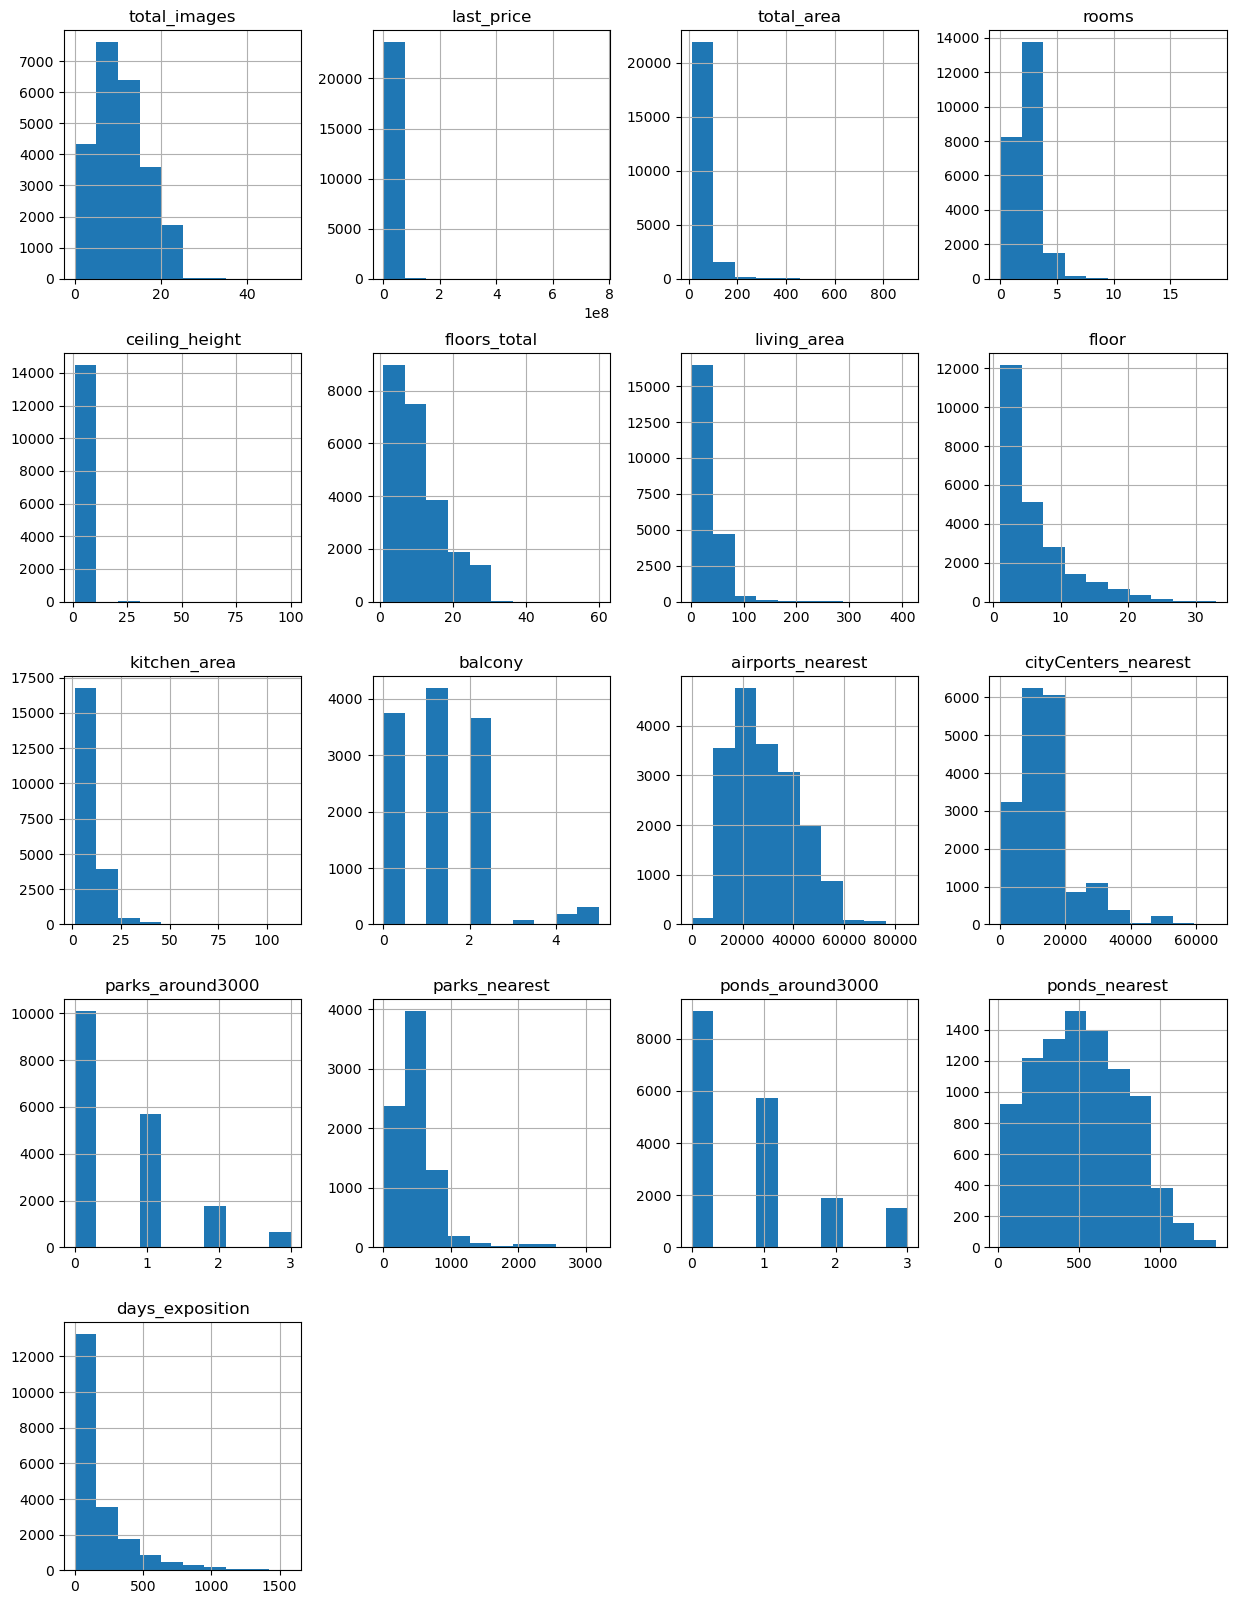

In [3]:
data.hist(figsize=(15, 20));
plt.title('Распределение параметров недвижимости');

## Предобработка данных

#### Выявим пропуски в данных

In [4]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


#### Рассмотрим возможность заполнения пропусков в каждом стобце.

1. ceiling_height - высота потолков. Заполнить пропуски было бы возможно, если бы в базе данных были адреса домов, так как в каждом доме высота потолков во всех квартирах одинаковая. В таком случае значения можно было бы взять из тех строк, где они есть при условии, что адрес совпадает.
2. floors_total - количество этажей в доме. Аналогично п. 1.
3. living_area - жилая площадь. Заполнить пропуски невозможно.
4. is_apartment - аппартаменты. Можно заполнить значениями False, так как, вероятно, менеджер решил, что для обычных домов это поле заполнять не требуется. Скорее всего, его проигнорировали в большинстве случаев.
5. kitchen_area - площадь кухни. Для квартир-студий можно заполнить 0. Остальные заполнить невозможно.
6. balcony - наличие балконов. Можно заполнить нулями, так как, скорее всего, балконов попросту нет, и менеджер проигнорировал это поле.
7. locality_name - населённый пункт. Заполнить пропуски названиями невозможно, заполним их пустыми строками для удобства в дальнейшем.
8. airports_nearest - расстояние до ближайшего аэропорта в метрах. Заполнить пропуски невозможно.
9. cityCenters_nearest - расстояние до центра города. Заполнить пропуски невозможно.
10. parks_around3000 - число парков в радиусе 3 км. Можно заполнить 0 те строки, где значения parks_nearest более 3000. В остальных случаях заполнить невозможно.
11. parks_nearest - расстояние до ближайшего парка. Без адреса заполнить невозможно.
12. ponds_around3000 - аналогично п.10
13. ponds_nearest - расстояние до ближайшего водоёма. Аналогично п.11.
14. days_exposition - сколько дней было размещено объявление. Заполнить пропуски невозможно.


#### Заполним пропуски в выбранных столбцах и посмотрим на результат

In [5]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data.loc[data['studio'] == True, 'kitchen_area'] = data.loc[data['studio'] == True, 'kitchen_area'].fillna(0)
data['balcony'] = data['balcony'].fillna(0)
data['locality_name'] = data['locality_name'].fillna('')
data.loc[data['parks_nearest'] > 3000, 'parks_around3000'] = data.loc[data['parks_nearest'] > 3000, 'parks_around3000'].fillna(0)
data.loc[data['ponds_nearest'] > 3000, 'ponds_around3000'] = data.loc[data['ponds_nearest'] > 3000, 'ponds_around3000'].fillna(0)

print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2129
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


#### Займёмся преобразованием типов данных, где это требуется. Для начала выведём информацию о них.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21570 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Следущие столбцы состоят из целочисленных переменных и не имеют пропусков, поэтому целесообразно изменить их тип с float64 на int64: last_price, balcony.

Переменная first_day_exposition содержит дату и время, поэтому её переведём из типа object в datetime, который нагляднее смотрится и с которым удобнее дальше работать.

In [7]:
data['last_price'] = data['last_price'].astype('int', errors='ignore')
data['balcony'] = data['balcony'].astype('int', errors='ignore')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21570 non-null  float64       
 13  balcony         

#### Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты. 

In [8]:
print(data['locality_name'].sort_values().unique())

['' 'Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'дер

Первое, что бросается в глаза - запись слова "поселок" с е и ё. Заменим везде вариант с е на вариант с ё.

In [9]:
for i in range(len(data['locality_name'])):
    data.loc[i, 'locality_name'] = data.loc[i, 'locality_name'].replace('поселок', 'посёлок')

display(data.head(10))

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000      108.00           2019-03-07      3   
1             7     3350000       40.40           2018-12-04      1   
2            10     5196000       56.00           2015-08-20      2   
3             0    64900000      159.00           2015-07-24      3   
4             2    10000000      100.00           2018-06-19      2   
5            10     2890000       30.40           2018-09-10      1   
6             6     3700000       37.30           2017-11-02      1   
7             5     7915000       71.60           2019-04-18      2   
8            20     2900000       33.16           2018-05-23      1   
9            18     5400000       61.00           2017-02-26      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70          16.0        51.00      8         False   False   
1             NaN          11.0        18.60      1         False   False   
2             NaN           5.0        34.30      4         False   False   
3             NaN          14.0          NaN      9         False   False   
4            3.03          14.0        32.00     13         False   False   
5             NaN          12.0        14.40      5         False   False   
6             NaN          26.0        10.60      6         False   False   
7             NaN          24.0          NaN     22         False   False   
8             NaN          27.0        15.43     26         False   False   
9            2.50           9.0        43.60      7         False   False   

   open_plan  kitchen_area  balcony              locality_name  \
0      False         25.00        0            Санкт-Петербург   
1      False         11.00        2             посёлок Шушары   
2      False          8.30        0            Санкт-Петербург   
3      False           NaN        0            Санкт-Петербург   
4      False         41.00        0            Санкт-Петербург   
5      False          9.10        0  городской посёлок Янино-1   
6      False         14.40        1          посёлок Парголово   
7      False         18.90        2            Санкт-Петербург   
8      False          8.81        0             посёлок Мурино   
9      False          6.50        2            Санкт-Петербург   

   airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
0           18863.0              16028.0               1.0          482.0   
1           12817.0              18603.0               0.0            NaN   
2           21741.0              13933.0               1.0           90.0   
3           28098.0               6800.0               2.0           84.0   
4           31856.0               8098.0               2.0          112.0   
5               NaN                  NaN               NaN            NaN   
6           52996.0              19143.0               0.0            NaN   
7           23982.0              11634.0               0.0            NaN   
8               NaN                  NaN               NaN            NaN   
9           50898.0              15008.0               0.0            NaN   

   ponds_around3000  ponds_nearest  days_exposition  
0               2.0          755.0              NaN  
1               0.0            NaN             81.0  
2               2.0          574.0            558.0  
3               3.0          234.0            424.0  
4               1.0           48.0            121.0  
5               NaN            NaN             55.0  
6               0.0            NaN            155.0  
7               0.0            NaN              NaN  
8               NaN            NaN            189.0  
9               0.0            NaN            289.0

Второй момент, на который можно обратить внимание - наличие названия населённого пункта с его типом и без. Применим к списку метод find, например, к населённому пункту Мурино, чтобы убедится в этом.

In [10]:
local_string = data['locality_name'].to_list()
murino = []
for i in range(len(local_string)):
    j = local_string[i].find('Мурино')
    if j != -1:
        murino.append(local_string[i])
print(pd.unique(murino))

['посёлок Мурино' 'Мурино']


#### Для устранения неявных дубликатов с типами населённых пунктов, предлагается извлечь типы населённых пунктов в отдельный столбец. 

In [11]:
# создание списка из типов населённых пунктов
list_types = ['коттеджный посёлок ', 'городской посёлок ', 'посёлок городской ', 'посёлок городского типа ', 'деревня ', 
              'садовое товарищество ','садоводческое некоммерческое товарищество ', 'село ', 'посёлок ']

# создадим функцию, которая будет собирать типы населённых пунктов, если они указаны
def town_type(row):
    for value in list_types:
        if value in row:
            return value
    return ''

# применяем функцию        
data['local_type'] = data['locality_name'].apply(town_type)
print(data['local_type'].sort_values().unique()) 

['' 'городской посёлок ' 'деревня ' 'коттеджный посёлок ' 'посёлок '
 'посёлок городского типа ' 'садоводческое некоммерческое товарищество '
 'садовое товарищество ' 'село ']


#### Далее создадим ряд с названиями без типов н/п.

In [12]:
for i in range(len(data['locality_name'])):
    data.loc[i, 'local_without_type'] = data.loc[i, 'locality_name'].replace((data.loc[i, 'local_type']), '')
    
print(data['local_without_type'].sort_values().unique())

['' 'Агалатово' 'Александровская' 'Алексеевка' 'Аннино' 'Аро' 'Барышево'
 'Батово' 'Бегуницы' 'Белогорка' 'Белоостров' 'Бокситогорск'
 'Большая Вруда' 'Большая Ижора' 'Большая Пустомержа' 'Большие Колпаны'
 'Большое Рейзино' 'Большой Сабск' 'Бор' 'Борисова Грива' 'Бугры'
 'Будогощь' 'Ваганово' 'Важины' 'Вартемяги' 'Вахнова Кара' 'Виллози'
 'Вознесенье' 'Возрождение' 'Войсковицы' 'Войскорово' 'Володарское'
 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Вырица' 'Выскатка'
 'Высокоключевой' 'Высоцк' 'Гаврилово' 'Гарболово' 'Гатчина' 'Гладкое'
 'Глажево' 'Глебычево' 'Глинка' 'Гончарово' 'Горбунки' 'Гостилицы'
 'Громово' 'Дзержинского' 'Дружная Горка' 'Дружноселье' 'Дубровка'
 'Елизаветино' 'Ефимовский' 'Жилгородок' 'Жилпосёлок' 'Житково'
 'Заводской' 'Заклинье' 'Заневка' 'Запорожское' 'Зеленогорск' 'Зимитицы'
 'Ивангород' 'Извара' 'Ильичёво' 'Иссад' 'Калитино' 'Каложицы' 'Кальтино'
 'Каменногорск' 'Камышовка' 'Каськово' 'Келози' 'Кивеннапа Север'
 'Кикерино' 'Кингисепп' 'Кингисеппский' 'Кипен

#### Cгрупируем датафрейм по названиям населённых пунктов и соберём уникальные значения из переменной local_type для каждого населённого пункта.

In [13]:
group_of_names = data.groupby('local_without_type')['local_type'].unique()
print(group_of_names.head())

local_without_type
                           []
Агалатово          [деревня ]
Александровская    [посёлок ]
Алексеевка         [посёлок ]
Аннино             [посёлок ]
Name: local_type, dtype: object


#### Ну и, наконец, присоединим недостающие типы населённых пунктов к их названиям, применяя индексацию к сгруппированному выше Series.

In [14]:
for i in range(len(data['locality_name'])):
    data.loc[i, 'local_name_new'] = group_of_names[data.loc[i, 'local_without_type']][0] + data.loc[i, 'local_without_type']
    
display(data['local_name_new'].sort_values().unique())

array(['', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Лодейное Поле', 'Ломоносов', 'Луга',
       'Любань', 'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск',
       'Петергоф', 'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск',
       'Пушкин', 'Санкт-Петербург', 'Светогорск', 'Сертолово',
       'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин',
       'Тосно', 'Шлиссельбург', 'городской посёлок Большая Ижора',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Свирьстрой', 'городской посёлок Янино-1',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'де

Удалим созданные и уже ненужные столбцы local_without_type и local_type

In [15]:
data['locality_name'] = data['local_name_new']
data = data.drop(columns = ['local_without_type', 'local_type', 'local_name_new'])

#### Найдём и устраним редкие и выбивающиеся значения.

In [16]:
data.describe()

total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23613.000000  21796.000000  23699.000000  21570.000000  23699.000000   
mean      10.673824     34.457852      5.892358     10.496794      0.591080   
std        6.597173     22.030445      4.885249      5.949767      0.959298   
min        1.000000      2.000000      1.000000      0.000000      0.000000   
25%        5.000000     18.600000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.010000      0.000000   
75%       16.000000     42.300000      8.000000     12.000000      1.000000   
max       60.000000    409.700000     33.000000    112.000000      5.000000   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count      18157.000000         18180.000000      18181.000000    8079.000000   
mean       28793.672193         14191.277833          0.611408     490.804555   
std        12630.880622          8608.386210          0.802074     342.317995   
min            0.000000           181.000000          0.000000       1.000000   
25%        18585.000000          9238.000000          0.000000     288.000000   
50%        26726.000000         13098.500000          0.000000     455.000000   
75%        37273.000000         16293.000000          1.000000     612.000000   
max        84869.000000         65968.000000          3.000000    3190.000000   

       ponds_around3000  ponds_nearest  days_exposition  
count      18181.000000    9110.000000     20518.000000  
mean           0.770255     517.980900       180.888634  
std            0.938346     277.720643       219.727988  
min            0.000000      13.000000         1.000000  
25%            0.000000     294.000000        45.000000  
50%            1.000000     502.000000        95.000000  
75%            1.000000     729.000000       232.000000  
max            3.000000    1344.000000      1580.000000

Нехарактерные особенности, которые можно заметить:
1. Количество комнат - 0, 19.
2. Высота потолков - 100 м.
3. Количество дней размещения - 1580 д.

In [17]:
# начнём с потолков
display(data.query('ceiling_height > 5').sort_values(by='ceiling_height', ascending=False))

total_images  last_price  total_area first_day_exposition  rooms  \
22869             0    15000000        25.0           2018-07-25      1   
22336            19     9999000        92.4           2019-04-05      2   
3148             14     2900000        75.0           2018-11-12      3   
21377            19     4900000        42.0           2017-04-18      1   
22938            14     4000000        98.0           2018-03-15      4   
10773             8     3800000        58.0           2017-10-13      2   
21824            20     2450000        44.0           2019-02-12      2   
4876              7     3000000        25.0           2017-09-27      0   
20478            11     8000000        45.0           2017-07-18      1   
5246              0     2500000        54.0           2017-10-13      2   
5807             17     8150000        80.0           2019-01-09      2   
17857             1     3900000        56.0           2017-12-22      3   
5669              4     4400000        50.0           2017-08-08      2   
18545             6     3750000        43.0           2019-03-18      2   
14382             9     1700000        35.0           2015-12-04      1   
11285             0     1950000        37.0           2019-03-20      1   
355              17     3600000        55.2           2018-07-12      2   
9379              5     3950000        42.0           2017-03-26      3   
4643              0     4300000        45.0           2018-02-01      2   
6246              6     3300000        44.4           2019-03-25      2   
5076              0     3850000        30.5           2018-10-03      1   
20507            12     5950000        60.0           2018-02-19      2   
17496            15     6700000        92.9           2019-02-19      3   
15061            19     5600000        56.4           2018-05-11      2   
22309            20     5300000        45.0           2017-09-30      1   
5863             20     5650000        45.0           2018-08-15      1   
15743            14     5600000        67.0           2016-11-11      3   
17442             0     5350000        54.0           2015-06-16      2   
3474              3     1400000        30.0           2018-03-16      1   
20264            17   119000000       187.6           2017-07-10      4   
21227             0     8200000        71.0           2017-07-21      0   
1388             20    59800000       399.0           2015-01-21      5   
7578             17    38000000       143.0           2017-11-02      3   
1026             20   155000000       310.0           2018-10-12      5   
12628            14     3900000        50.0           2018-03-29      1   
464              15    66571000       280.3           2015-06-11      6   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
22869           100.0           5.0         14.0      5          True   False   
22336            32.0           6.0         55.5      5         False   False   
3148             32.0           3.0         53.0      2         False   False   
21377            27.5          24.0         37.7     19         False   False   
22938            27.0           2.0         73.0      2          True   False   
10773            27.0          10.0         30.1      3         False   False   
21824            27.0           2.0         38.0      2         False   False   
4876             27.0          25.0         17.0     17         False   False   
20478            27.0           4.0         22.0      2         False   False   
5246             27.0           5.0         30.0      3         False   False   
5807             27.0          36.0         41.0     13         False   False   
17857            27.0           5.0         33.0      4         False   False   
5669             26.0           9.0         21.3      3         False   False   
18545            25.0           5.0         29.0      3         False   False   
14382           

Примем, что значения высоты потолков более 7 метров являются ошибочными. Будем считать, что значения высоты потолков от 25 получены в результате пропуска менеджером разделителя разрядов. Поэтому перед фильтрацией данных разделим все значения выше 25 на 10.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21570 non-null  float64       
 13  balcony         

In [19]:
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] /= 10
display(data['ceiling_height'].describe().reset_index())

index  ceiling_height
0  count    14504.000000
1   mean        2.733740
2    std        0.425691
3    min        1.000000
4    25%        2.510000
5    50%        2.650000
6    75%        2.800000
7    max       24.000000

In [20]:
# далее посмотрим на количество комнат
display(data.query('rooms > 8').sort_values(by='rooms', ascending=False))

total_images  last_price  total_area first_day_exposition  rooms  \
14498             6    32250000       374.6           2018-06-09     19   
18848             6    28500000       270.0           2015-03-02     16   
5358             20    65000000       590.0           2019-02-14     15   
20829             6    28659000       245.4           2016-03-31     14   
866               5    25000000       363.0           2017-12-23     14   
19540             8   420000000       900.0           2017-12-06     12   
9688              8    33000000       194.1           2017-02-07     11   
648               3    17500000       183.7           2018-07-01     11   
18119             4    15500000       216.1           2016-07-04     10   
18891            11    40000000       290.0           2016-06-21     10   
4149              6    23000000       272.6           2018-01-11     10   
13019             0    22250000       249.9           2019-04-23      9   
9550             10    23500000       313.0           2017-02-13      9   
8860             12    17000000       235.0           2018-07-14      9   
15151            15    88000000       400.0           2019-03-27      9   
16915            14    29000000       292.2           2017-01-12      9   
8822             14    49968900       398.0           2017-07-12      9   
20791             0    24000000       250.0           2019-04-23      9   
13397            14    19500000       309.7           2016-02-03      9   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
14498             NaN           5.0        264.5      2         False   False   
18848            3.00           4.0        180.0      4         False   False   
5358             3.50           6.0        409.0      3         False   False   
20829             NaN           4.0        168.3      2         False   False   
866              3.16           5.0        222.0      4         False   False   
19540            2.80          25.0        409.7     25         False   False   
9688             3.43           5.0        129.0      2         False   False   
648              3.40           7.0        138.8      7         False   False   
18119            3.15           5.0        161.4      2         False   False   
18891            3.50           6.0        189.4      6         False   False   
4149             3.14           7.0        145.9      7         False   False   
13019            3.20           5.0        157.0      5         False   False   
9550             3.20           6.0        179.2      5         False   False   
8860             3.00           6.0          NaN      3         False   False   
15151            2.50           2.0        250.0      1         False   False   
16915            3.35           5.0        225.9      4         False   False   
8822             3.00           2.0        160.1      1         False   False   
20791            3.20           5.0        160.6      3         False   False   
13397             NaN           5.0        199.0      5         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
14498      False          27.6        0  Санкт-Петербург           19497.0   
18848      False          13.0        1  Санкт-Петербург           23575.0   
5358       False         100.0        0  Санкт-Петербург           24447.0   
20829      False          25.9        0  Санкт-Петербург           21104.0   
866        False          16.6        0  Санкт-Петербург           38076.0   
19540      False         112.0        0  Санкт-Петербург           30706.0   
9688       False          11.9        0  Санкт-Петербург           21469.0   
648        False          13.3        0  Санкт-Петербург           23606.0   
18119      False          19.8        0  Санкт-Петербург           24353.0   
18891      False          30.0        1  Санкт-Петербург           26229.0   
4149       False          1

В принципе жилая площадь растёт с количеством комнат, поэтому средняя площадь одной комнаты не меньше 10 м2. Надо спросить у риэлторов, бывают ли квартиры с 19 комнатами). Сейчас в Москве в продаже больше 6 комнат в квартирах нет.

Посмотрим теперь что за квартиры без комнат.

In [21]:
display(data.query('rooms == 0').sort_values(by='total_area', ascending=False)) 

total_images  last_price  total_area first_day_exposition  rooms  \
19392             5    71000000       371.0           2018-07-26      0   
20082            10    16300000        98.4           2017-11-08      0   
3458              6     7400000        73.6           2017-05-18      0   
21227             0     8200000        71.0           2017-07-21      0   
13613            16     8100000        58.4           2019-04-26      0   
...             ...         ...         ...                  ...    ...   
8755              1     1350000        18.8           2017-11-22      0   
12996             8     1900000        18.0           2019-01-25      0   
716               5     1500000        17.0           2017-06-07      0   
9412              5     2100000        16.0           2017-12-10      0   
8886             10     2450000        15.5           2018-08-22      0   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
19392            3.57           7.0          NaN      6         False   False   
20082            3.10           5.0         60.5      2         False    True   
3458              NaN           3.0         50.0      1         False    True   
21227            5.80           5.0         68.0      5         False    True   
13613            3.30           7.0         33.0      6         False    True   
...               ...           ...          ...    ...           ...     ...   
8755             2.75          19.0         15.8      1         False    True   
12996            2.60           5.0         16.0      3         False    True   
716              2.70           9.0         12.0      1         False    True   
9412              NaN           6.0         13.0      1         False   False   
8886              NaN           5.0         10.0      2         False    True   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
19392       True           NaN        0  Санкт-Петербург           25257.0   
20082      False           0.0        0  Санкт-Петербург           26972.0   
3458       False           0.0        0  Санкт-Петербург           26581.0   
21227      False           0.0        0  Санкт-Петербург           20170.0   
13613      False           0.0        0  Санкт-Петербург           14509.0   
...          ...           ...      ...              ...               ...   
8755       False           0.0        0  Санкт-Петербург           37636.0   
12996      False           0.0        0  Санкт-Петербург           19573.0   
716        False           0.0        0   посёлок Шушары           18654.0   
9412        True           NaN        0  Санкт-Петербург           20735.0   
8886       False           0.0        0  Санкт-Петербург           24326.0   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
19392               6060.0               1.0          761.0               1.0   
20082               5819.0               0.0            NaN               1.0   
3458                6085.0               0.0            NaN               1.0   
21227               1261.0               2.0          295.0               3.0   
13613               8288.0               0.0            NaN               0.0   
...                    ...               ...            ...               ...   
8755               14479.0               0.0            NaN               1.0   
12996              15772.0               2.0          149.0               2.0   
716                29846.0               0.0            NaN               0.0   
9412                2111.0               2.0          228.0               3.0   
8886                4589.0               0.0            NaN               1.0   

       ponds_nearest  days_exposition  
19392          584.0             90.0  
20082          674.0            537.0  
3458           348.0             60.0  
21227          366.0             30.0  
13613            NaN   

Проверим есть ли среди них студии.

In [22]:
display(data.query('rooms == 0 & studio == True').sort_values(by='total_area', ascending=False))

total_images  last_price  total_area first_day_exposition  rooms  \
20082            10    16300000        98.4           2017-11-08      0   
3458              6     7400000        73.6           2017-05-18      0   
21227             0     8200000        71.0           2017-07-21      0   
13613            16     8100000        58.4           2019-04-26      0   
10008            20     5050000        44.2           2017-09-14      0   
...             ...         ...         ...                  ...    ...   
9817              8     2190000        19.0           2018-10-12      0   
8755              1     1350000        18.8           2017-11-22      0   
12996             8     1900000        18.0           2019-01-25      0   
716               5     1500000        17.0           2017-06-07      0   
8886             10     2450000        15.5           2018-08-22      0   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
20082            3.10           5.0         60.5      2         False    True   
3458              NaN           3.0         50.0      1         False    True   
21227            5.80           5.0         68.0      5         False    True   
13613            3.30           7.0         33.0      6         False    True   
10008            2.70           9.0         32.2      1         False    True   
...               ...           ...          ...    ...           ...     ...   
9817             3.50           5.0         15.0      1         False    True   
8755             2.75          19.0         15.8      1         False    True   
12996            2.60           5.0         16.0      3         False    True   
716              2.70           9.0         12.0      1         False    True   
8886              NaN           5.0         10.0      2         False    True   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
20082      False           0.0        0  Санкт-Петербург           26972.0   
3458       False           0.0        0  Санкт-Петербург           26581.0   
21227      False           0.0        0  Санкт-Петербург           20170.0   
13613      False           0.0        0  Санкт-Петербург           14509.0   
10008      False           0.0        0  Санкт-Петербург           24329.0   
...          ...           ...      ...              ...               ...   
9817       False           0.0        0  Санкт-Петербург           29561.0   
8755       False           0.0        0  Санкт-Петербург           37636.0   
12996      False           0.0        0  Санкт-Петербург           19573.0   
716        False           0.0        0   посёлок Шушары           18654.0   
8886       False           0.0        0  Санкт-Петербург           24326.0   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
20082               5819.0               0.0            NaN               1.0   
3458                6085.0               0.0            NaN               1.0   
21227               1261.0               2.0          295.0               3.0   
13613               8288.0               0.0            NaN               0.0   
10008               5955.0               0.0            NaN               2.0   
...                    ...               ...            ...               ...   
9817                8264.0               2.0          383.0               1.0   
8755               14479.0               0.0            NaN               1.0   
12996              15772.0               2.0          149.0               2.0   
716                29846.0               0.0            NaN               0.0   
8886                4589.0               0.0            NaN               1.0   

       ponds_nearest  days_exposition  
20082          674.0            537.0  
3458           348.0             60.0  
21227          366.0             30.0  
13613            NaN              NaN  
10008          520.0   

И, действительно, есть. Для них возможно заполнить поле rooms значениями 1.

In [23]:
data.loc[(data['rooms'] == 0) & (data['studio'] == True), 'rooms'] = 1

data.query('studio == True')['rooms'].unique()

array([1], dtype=int64)

Далее займёмся днями размещения. Максимальное значение 1580 д. Сомнительно, что за 5 лет много объектов так и не смогли продать. Посмотрим, сколько объектов с длительным сроком размещения, т.е. между 3 и 4 квартилями.

In [24]:
data.query('days_exposition > 232')['total_area'].count()

5101

Довольно таки много. И около 1 % объекты с размещением больше 3 лет.

В общей таблице со статистикой выбивается минимальное значение цены квартиры в 12000 р. Можно построить гистограмму для дешёвых квартир, а также вывести информацию об этих квартирах, чтобы узнать сколько таких квартир вообще.

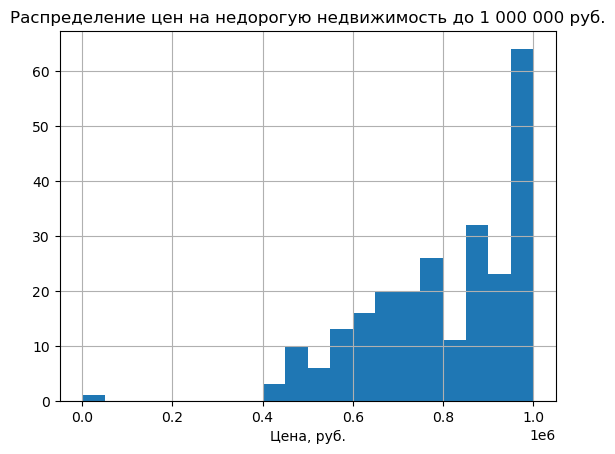

In [25]:
data['last_price'].hist(bins=20, range=(0, 1*pow(10,6)));
plt.title('Распределение цен на недорогую недвижимость до 1 000 000 руб.');
plt.xlabel('Цена, руб.');

In [26]:
display(data[data['last_price'] < pow(10,5)])

total_images  last_price  total_area first_day_exposition  rooms  \
8793             7       12190       109.0           2019-03-20      2   

      ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
8793            2.75          25.0         32.0     25         False   False   

      open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
8793      False          40.5        0  Санкт-Петербург           36421.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
8793               9176.0               1.0          805.0               0.0   

      ponds_nearest  days_exposition  
8793            NaN              8.0

In [27]:
# удалим этот странный объект
data_filt = data
data_filt.drop(labels = [8793],axis = 0, inplace=True)

Будем считать, что квартиры с числом комнат больше 6 будем считать аномальными. Посмотрим сколько объектов с аномальными значениями.

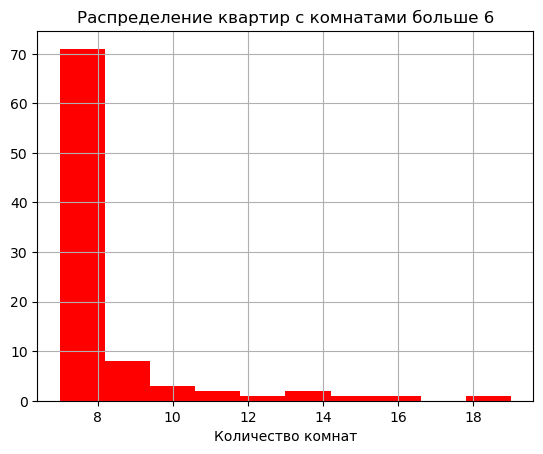

In [28]:
data_filt['rooms'].hist(bins=10, range=(7, 19), color='red');
plt.title('Распределение квартир с комнатами больше 6');
plt.xlabel('Количество комнат');

Спокойно можно отбросить до 100 странных объектов.

In [29]:
data_filt = data_filt[data_filt['rooms'] < 7]

Также откинем все значения, где число комнат равно 0.

In [30]:
data_filt = data_filt[data_filt['rooms'] > 0]

Посмотрим, что может быть не так с общей площадью.

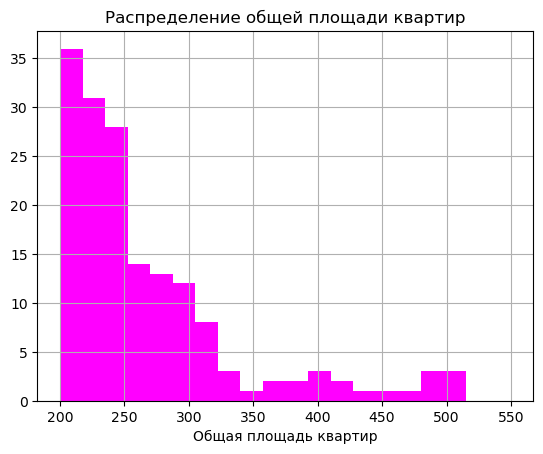

In [31]:
plt.title('Распределение общей площади квартир');
plt.xlabel('Общая площадь квартир');
data_filt['total_area'].hist(bins=20, range=(200, 550), color='magenta');

In [32]:
print(data_filt.loc[(data_filt['total_area']>200), 'rooms'].unique())

[4 6 3 5 1]


Посмотрев количество комнат для квартир с площадью больше 200 квадратов, можно наткнуться на аномальное значение.

In [33]:
display(data_filt.loc[((data_filt['total_area']>200) & (data_filt['rooms'] == 1)), :])

total_images  last_price  total_area first_day_exposition  rooms  \
9826             1    43185328       494.1           2017-05-12      1   

      ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
9826            2.85          12.0          NaN      3         False   False   

      open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
9826      False           NaN        0  Санкт-Петербург           28529.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
9826               6832.0               1.0          592.0               0.0   

      ponds_nearest  days_exposition  
9826            NaN              5.0

Не может быть одна комната в квартире с общей площадью 500 м2. Этот объект лучше отфильтровать. 

Проверим соотношения общей и жилой площади к количеству комнат и откинем все строки со значения выше 25 для жилой и выше 50 для общей площадей.

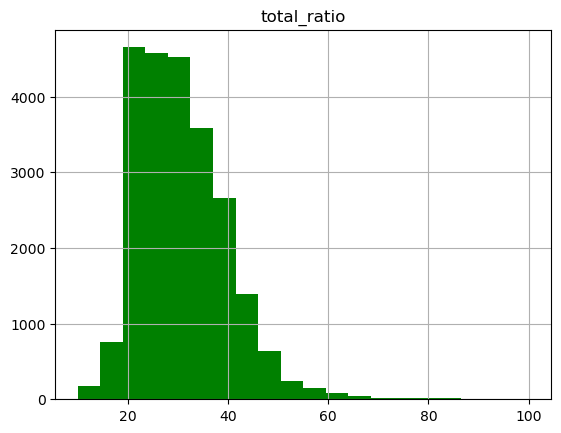

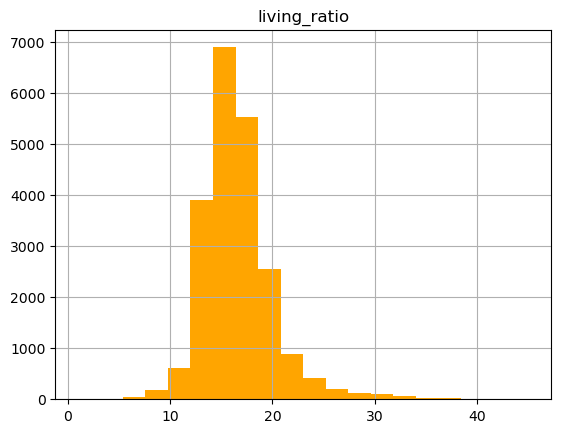

In [34]:
data_filt['total_ratio'] = data_filt['total_area'] / data_filt['rooms']
data_filt['living_ratio'] = data_filt['living_area'] / data_filt['rooms']

plt.title('total_ratio')
data_filt['total_ratio'].hist(bins=20, range=(10, 100), color='green');
plt.show()

plt.title('living_ratio')
data_filt['living_ratio'].hist(bins=20, range=(1, 45), color='orange');
plt.show()

Гистограммы показали и оптимальные минимумы для соотношений: 7 - жилая, 14 - общая. 
Итак, отфильтруем значения по диапазонам коэффициентов.

In [35]:
data_filt = data_filt.query('total_ratio >= 14 & total_ratio <= 50 & living_ratio >= 7 & living_ratio <= 30')

Сравним размеры исходного и отфильтрованного датафреймов.

In [36]:
print(round(data_filt.shape[0] / data.shape[0], 3))

0.882


Исключено 11,8% значений.

#### Добавим новые столбцы в датафрейм. 

Первым добавим цену одного квадратного метра. Следующими добавим порядковый номер дня недели от 0 до 6, месяц и год публикации объявления. Ну и, наконец, расстояние в км.

In [37]:
# цена квадратного метра
data_filt['price_per_m2'] = data_filt['last_price'] / data_filt['total_area']

# вытаскиеваем информацию из даты
data_filt['day_of_week'] = data_filt['first_day_exposition'].dt.dayofweek
data_filt['month'] = data_filt['first_day_exposition'].dt.month
data_filt['year'] = data_filt['first_day_exposition'].dt.year

# расстояние до центра города в километрах
data_filt['cityCenters_km'] = round(data_filt['cityCenters_nearest'] / 1000, 0)

display(data_filt.head())

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
4             2    10000000       100.0           2018-06-19      2   
5            10     2890000        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70          16.0         51.0      8         False   False   
1             NaN          11.0         18.6      1         False   False   
2             NaN           5.0         34.3      4         False   False   
4            3.03          14.0         32.0     13         False   False   
5             NaN          12.0         14.4      5         False   False   

   open_plan  kitchen_area  balcony              locality_name  \
0      False          25.0        0            Санкт-Петербург   
1      False          11.0        2             посёлок Шушары   
2      False           8.3        0            Санкт-Петербург   
4      False          41.0        0            Санкт-Петербург   
5      False           9.1        0  городской посёлок Янино-1   

   airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
0           18863.0              16028.0               1.0          482.0   
1           12817.0              18603.0               0.0            NaN   
2           21741.0              13933.0               1.0           90.0   
4           31856.0               8098.0               2.0          112.0   
5               NaN                  NaN               NaN            NaN   

   ponds_around3000  ponds_nearest  days_exposition  total_ratio  \
0               2.0          755.0              NaN         36.0   
1               0.0            NaN             81.0         40.4   
2               2.0          574.0            558.0         28.0   
4               1.0           48.0            121.0         50.0   
5               NaN            NaN             55.0         30.4   

   living_ratio   price_per_m2  day_of_week  month  year  cityCenters_km  
0         17.00  120370.370370            3      3  2019            16.0  
1         18.60   82920.792079            1     12  2018            19.0  
2         17.15   92785.714286            3      8  2015            14.0  
4         16.00  100000.000000            1      6  2018             8.0  
5         14.40   95065.789474            0      9  2018             NaN

#### Добавим тип этажа квартиры. Применим написанную функцию к датафрейму.

In [38]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data_filt['floor_type'] = data_filt.apply(floor_type, axis=1)

display(data_filt.head(10))

total_images  last_price  total_area first_day_exposition  rooms  \
0             20    13000000      108.00           2019-03-07      3   
1              7     3350000       40.40           2018-12-04      1   
2             10     5196000       56.00           2015-08-20      2   
4              2    10000000      100.00           2018-06-19      2   
5             10     2890000       30.40           2018-09-10      1   
6              6     3700000       37.30           2017-11-02      1   
8             20     2900000       33.16           2018-05-23      1   
9             18     5400000       61.00           2017-02-26      3   
10             5     5050000       39.60           2017-11-16      1   
11             9     3300000       44.00           2018-08-27      2   

    ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0             2.70          16.0        51.00      8         False   False   
1              NaN          11.0        18.60      1         False   False   
2              NaN           5.0        34.30      4         False   False   
4             3.03          14.0        32.00     13         False   False   
5              NaN          12.0        14.40      5         False   False   
6              NaN          26.0        10.60      6         False   False   
8              NaN          27.0        15.43     26         False   False   
9             2.50           9.0        43.60      7         False   False   
10            2.67          12.0        20.30      3         False   False   
11             NaN           5.0        31.00      4         False   False   

    open_plan  kitchen_area  balcony              locality_name  \
0       False         25.00        0            Санкт-Петербург   
1       False         11.00        2             посёлок Шушары   
2       False          8.30        0            Санкт-Петербург   
4       False         41.00        0            Санкт-Петербург   
5       False          9.10        0  городской посёлок Янино-1   
6       False         14.40        1          посёлок Парголово   
8       False          8.81        0             посёлок Мурино   
9       False          6.50        2            Санкт-Петербург   
10      False          8.50        0            Санкт-Петербург   
11      False          6.00        1                  Ломоносов   

    airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
0            18863.0              16028.0               1.0          482.0   
1            12817.0              18603.0               0.0            NaN   
2            21741.0              13933.0               1.0           90.0   
4            31856.0               8098.0               2.0          112.0   
5                NaN                  NaN               NaN            NaN   
6            52996.0              19143.0               0.0            NaN   
8                NaN                  NaN               NaN            NaN   
9            50898.0              15008.0               0.0            NaN   
10           38357.0              13878.0               1.0          310.0   
11           48252.0              51677.0               0.0            NaN   

    ponds_around3000  ponds_nearest  days_exposition  total_ratio  \
0                2.0          755.0              NaN    36.000000   
1                0.0            NaN             81.0    40.400000   
2                2.0          574.0            558.0    28.000000   
4                1.0           48.0            121.0    50.000000   
5                NaN            NaN             55.0    30.400000   
6                0.0            NaN            155.0    37.300000   
8                NaN            NaN            189.0    33.160000   
9                0.0            NaN            289.0    20.333333   
10               2.0          553.0            137.0    39.600000   
11               0.0            NaN              7.0    22.000000

## Исследовательский анализ данных

#### Cтроим гистограммы по всем интересующим нас параметрам

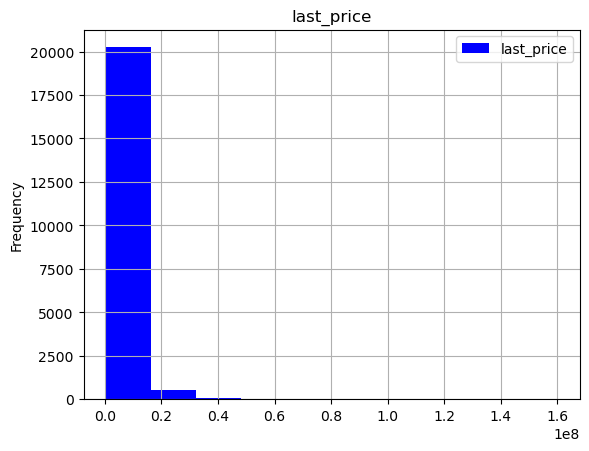

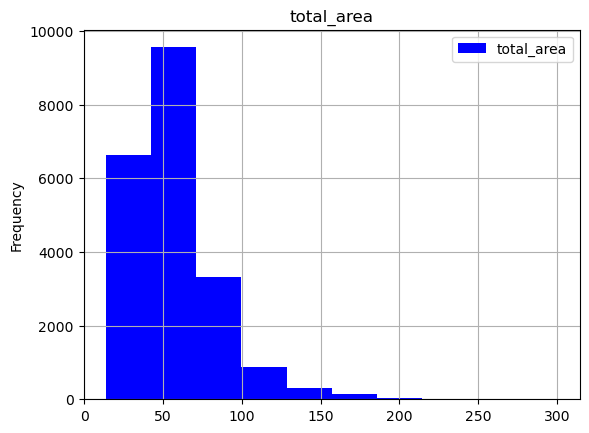

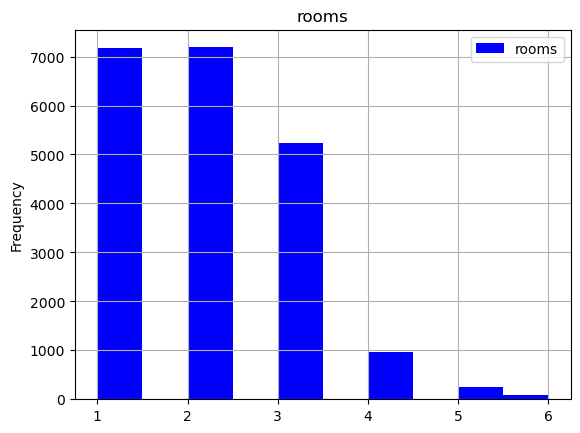

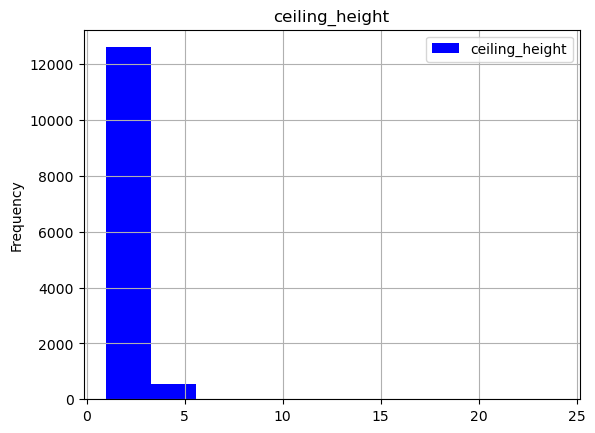

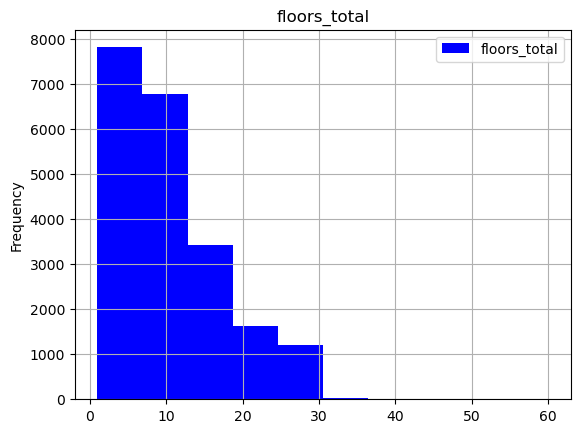

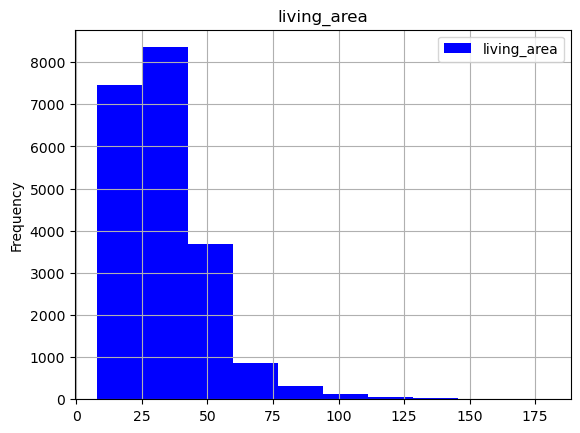

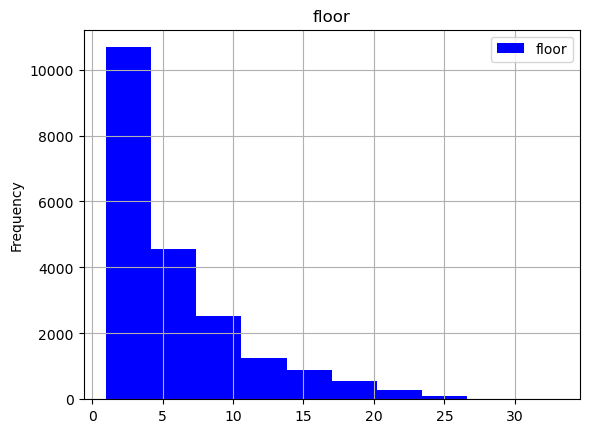

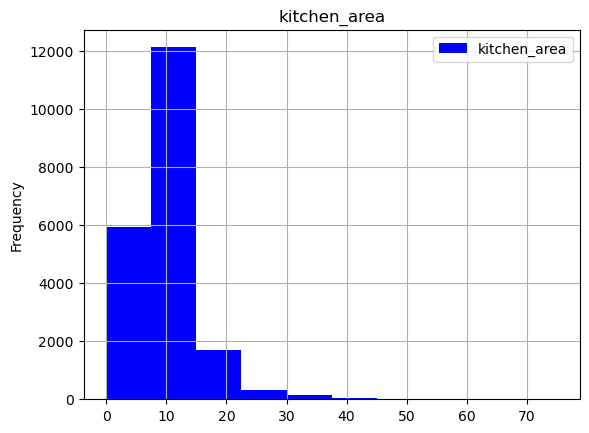

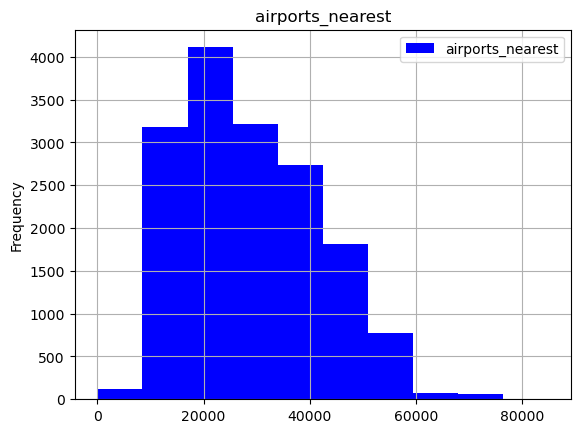

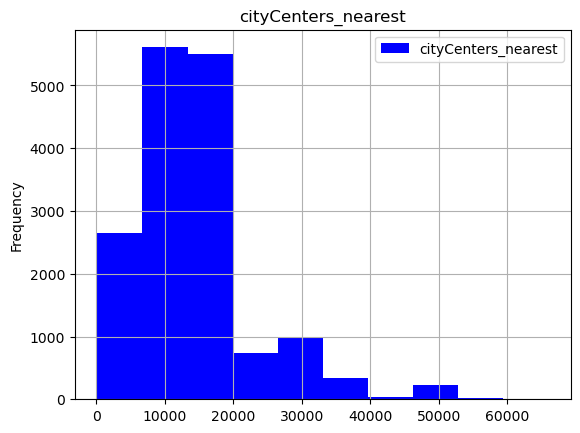

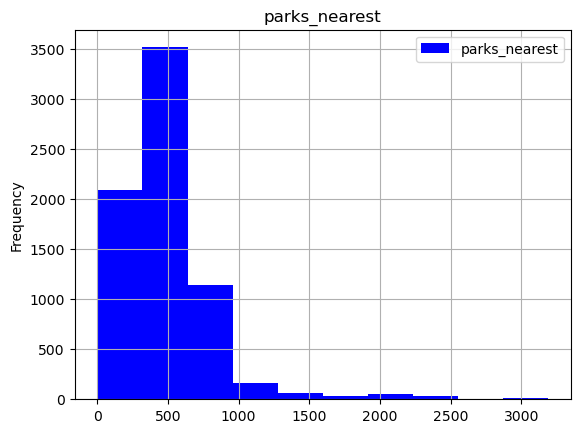

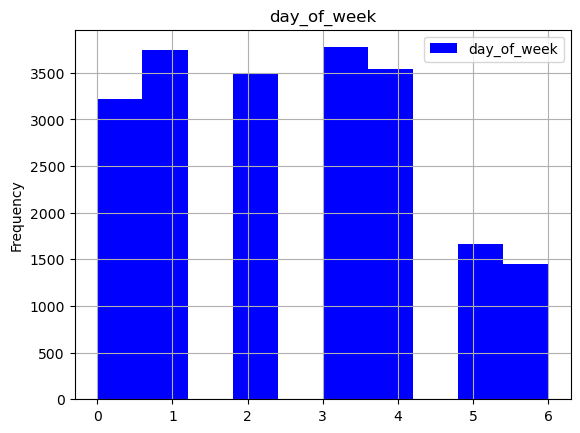

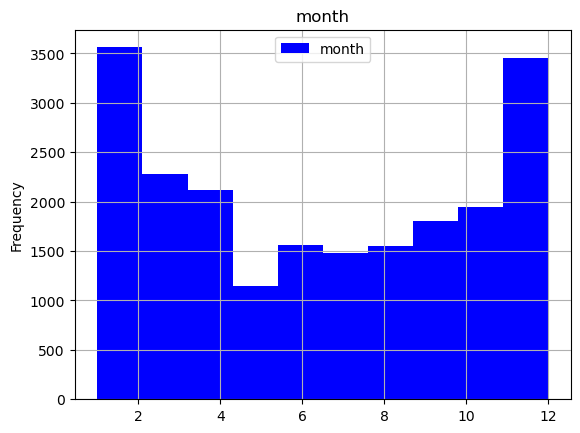

In [39]:
#data.columns - скопировали названия колонок :)
hist_list = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
        'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'day_of_week', 
        'month']

for name in hist_list:
    data_filt.plot(y=name, title=name, kind='hist', grid=True, color='blue')

Для большей информативности некоторые гистограммы придётся построить отдельно с указанием диапазона значений и числа корзин.

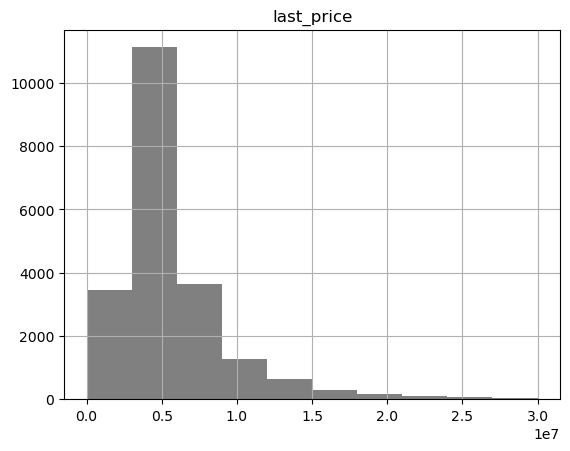

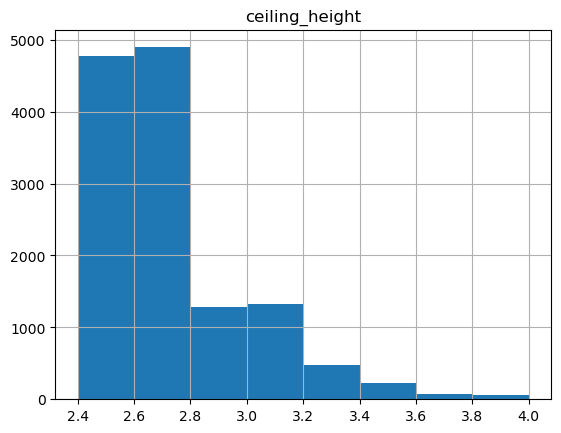

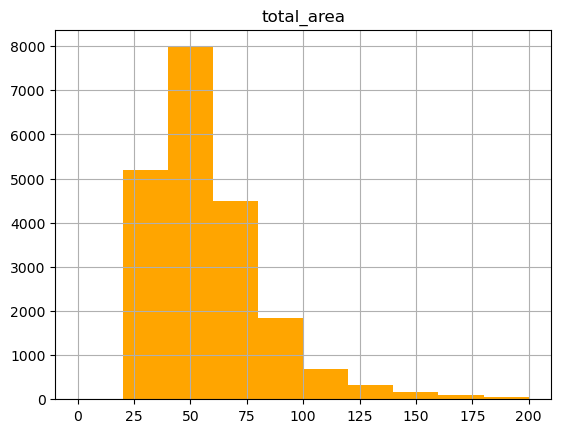

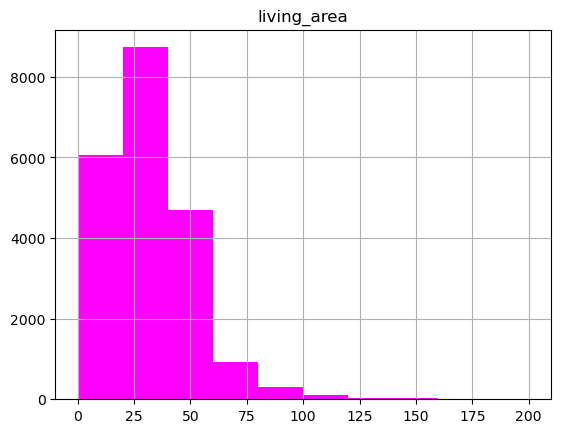

In [40]:
plt.title('last_price')
data_filt['last_price'].hist(bins=10, range=(0, 3*pow(10, 7)), color='grey')
plt.show() 

plt.title('ceiling_height')
data_filt['ceiling_height'].hist(bins=8, range=(2.4, 4))
plt.show()

plt.title('total_area')
data_filt['total_area'].hist(bins=10, range=(0, 200), color='orange')
plt.show()

plt.title('living_area')
data_filt['living_area'].hist(bins=10, range=(0, 200), color='magenta')
plt.show()

#### Отдельно построим гистограмму для категориальной переменной - типа этажа.

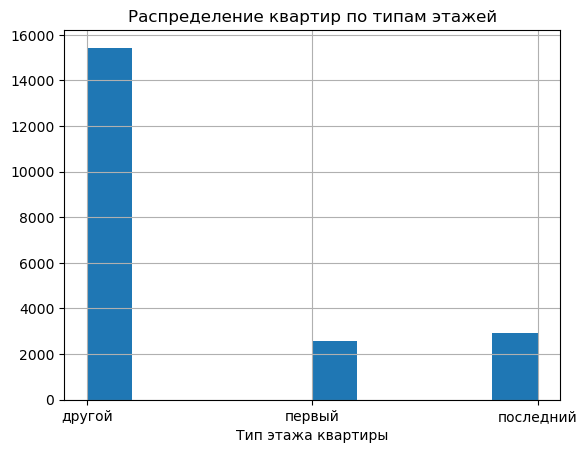

In [41]:
plt.title('Распределение квартир по типам этажей');
plt.xlabel('Тип этажа квартиры');
data_filt['floor_type'].hist();

#### Описание гистрограмм:

Стоимость практически всех квартир укладываются в ценовой дипазон до 15 млн. руб. Пик распределения в районе 4,5 млн.

Распределение общих площадей квартир пуассоновское. Пиковое значение на 50 м2. Большая часть квартир имеет площадь до 75 м2. Далее число квартир уменьшается с ростом площади.

Распределение жилых площадей квартир тоже пуассоновское. Пиковое значение на 30 м2. Квартир с жил.площадью более 60 м2 крайне мало.

Почти все квартиры имеют высоту потолков примерно от 2,4 до 2,8 метров. Ещё 3000 квартир с потолками до 3,2 м. Объектов недвижимости с большей высотой крайне мало.

Распределение по этажам резко убывающее. Большинство квартир расположены на этажах с 1 до 3.
Распределение этажности домов также убывающее, но более плавное. Около 9000 домов высотой до пяти этажей. 7500 - от 5 до 12.
4000 - от 12 до 18. Ну и ещё где-то 3500 - квартиры в высотках. 

Площадь кухни в большинстве квартир - до 10 м2. 5500 квартир - имеют площадь с 11 до 22 м2.

Расстояние до ближайшего аэропорта имеет пуассоновское распределение с пиком на 20 км.

Большинство квартир находятся в 7-20 км от центра. Четверть от этого большинства - до 7 км. Остальные удалены вплоть до 50 км.

Большинство квартир расположено вблизи парков, на расстоянии до 1 км.

Время размещения. В будни продавцы размещают объявления чаще, чем в выходные. При этом день ото дня показатели не меняются. Что касается месяцев, то чаще размещают объявления зимой, а меньше всего с мая по начало июня.

Количество квартир на первом и последнем этажах примерно одинаково и, что естественно, на порядок меньше, чем на остальных этажах.

#### Выполним анализ скорости продажи квартир.

Среднее количество дней размещения объявлений: 183.8
Медиана дней размещения объявлений: 101.0


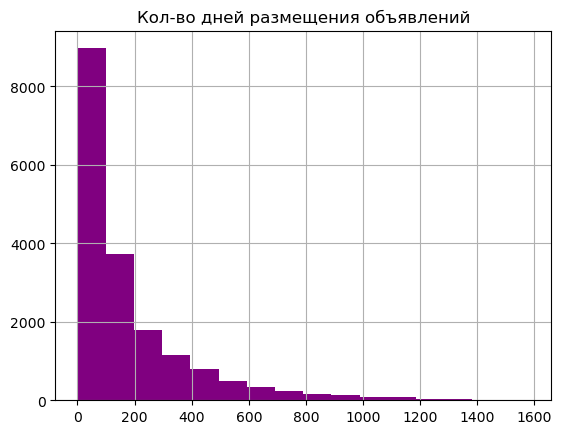

In [42]:
plt.title('Кол-во дней размещения объявлений')
data_filt['days_exposition'].hist(bins=16, color='purple')

print('Среднее количество дней размещения объявлений:', round(data_filt['days_exposition'].mean(), 1))
print('Медиана дней размещения объявлений:', data_filt['days_exposition'].median())

В среднем от размещения объявления до продажи квартиры проходит до 200 дней. Быстрые продажи - те, что расположены левее медианы. Необычно долгими можно назвать те продажи, когда объявление держалось на сайте дольше 600 дней. Максимальный срок - почти 4 года.

Отдельно можно посмотреть на размещение в диапазоне от 0 до 100 дней. Для наглядности возьмём нефильтрованные данные.

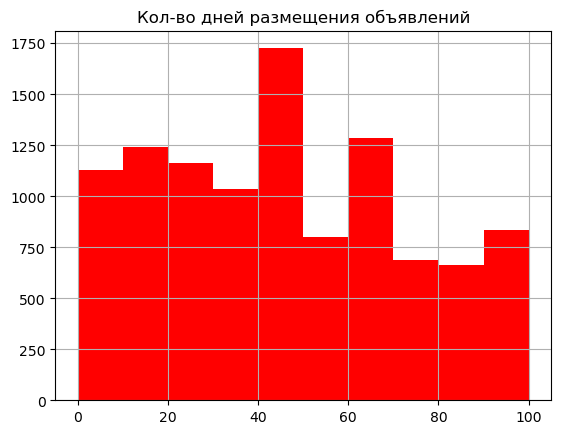

In [43]:
plt.title('Кол-во дней размещения объявлений')
data['days_exposition'].hist(bins=10, range=(0,100), color='red');

Есть два локальных пика на 45 и 65 дней размещения. Это связано с особенностью функционирования системы размещения объявлений. https://yandex.ru/support/realty/owner/home/add-ads-housing.html

#### Факторы, влияющие на общую (полную) стоимость объекта
Для изучения зависимости цены от параметров, описанных в задании (общей площади; жилой площади; площади кухни; количества комнат; 
этажа, на котором расположена квартира (первый, последний, другой); даты размещения) построим матрицу диаграмм рассеивания.

Матрица диаграмм рассеивания


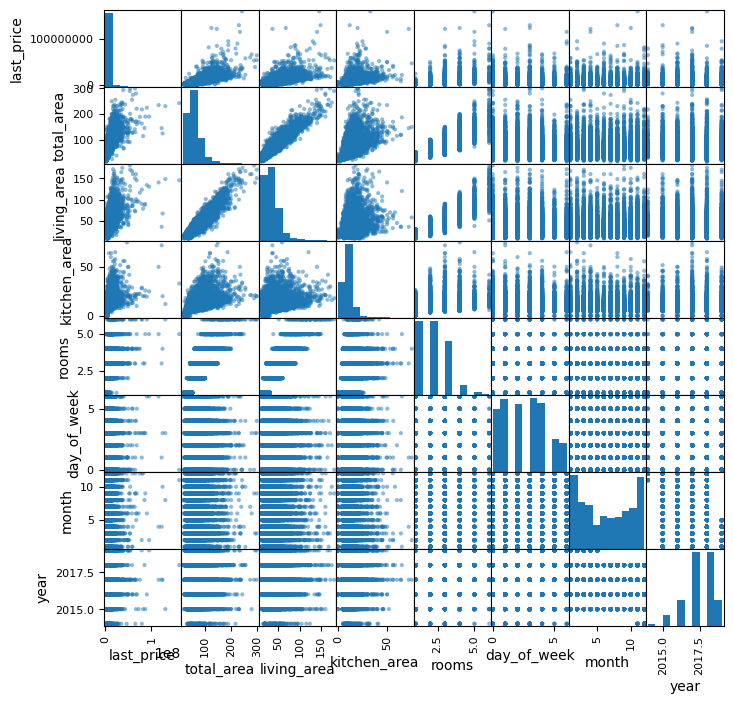

In [44]:
# отберём нужные столбцы
data_filt_2 = data_filt[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'day_of_week', 'month', 'year']]

# строим матрицу диаграмм рассеивания
print('Матрица диаграмм рассеивания');
pd.plotting.scatter_matrix(data_filt_2, figsize=(8, 8));

Нас интересуют зависимости параметров от цены - 1 строка или 1 столбец матрицы. Что касается первых четырёх графиков, то они характеризуются значительным разбросом точек, в целом, можно наблюдать небольшой линейный рост цены с увеличением каждого из параметров. От временных параметров размещения объявления цена не зависит.

#### Для визуализации зависимости цены от типа этажа, построим гистограммы распределения цены в каждой из 3 категорий этажа. 

Для этого группируем датафрейм по категориям этажа и рассчитаем медианы.

floor_type  last_price
0     другой   4800000.0
1     первый   3900000.0
2  последний   4300000.0

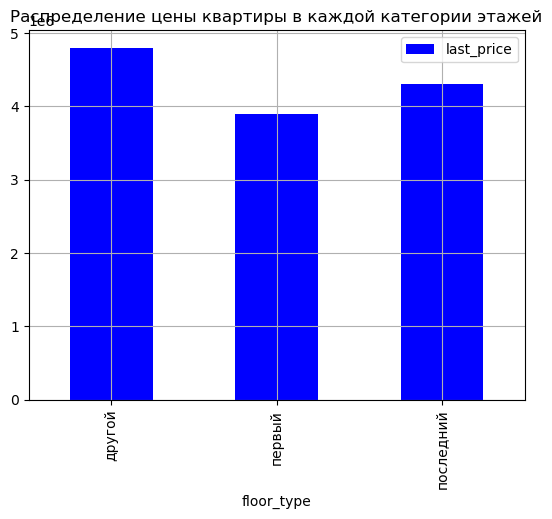

In [45]:
category_group = data_filt.groupby('floor_type', as_index = False)['last_price'].median()
display(category_group)

category_group.plot.bar(x='floor_type', y='last_price', grid=True, color='blue');
plt.title('Распределение цены квартиры в каждой категории этажей');

Медианная цена на квартиры на первых этажах самая низкая. Затем по росту цены идёт квартиры с медианной ценой на последних этажах, а самые дорогие расположены на остальных этажах.

Рассчитаем коэффициент корреляции Пирсона для общей площади, жилой площади, площади кухни и этажа.

In [46]:
display(data_filt[['last_price', 'total_area', 'living_area', 'kitchen_area', 'floor']].corr())

last_price  total_area  living_area  kitchen_area     floor
last_price      1.000000    0.726570     0.632406      0.541029  0.050797
total_area      0.726570    1.000000     0.938158      0.576197 -0.024514
living_area     0.632406    0.938158     1.000000      0.358824 -0.109080
kitchen_area    0.541029    0.576197     0.358824      1.000000  0.157787
floor           0.050797   -0.024514    -0.109080      0.157787  1.000000

Наблюдается сильная зависимость цены от общей и жилой площадей, что логично. Зависимость от площади кухни слабее. На этаж цена практически не влияет.

#### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

Сгруппируем датафрейм по названиям населённых пунктов и выведем круговую диаграмму, отображающую количество объявлений.

In [47]:
group_name_2 = (data_filt.groupby('locality_name')['last_price'].
                count().sort_values(ascending=False).
                reset_index().head(10))

fig = go.Figure(data=[go.Pie(labels=group_name_2['locality_name'],
                             values=group_name_2['last_price'])]) 
fig.update_layout(title='Число квартир по населённым пунктам',
                  width=800, height=600,annotations=[dict(
                      x=1.12, y=1.05, text='Населённый пункт', showarrow=False)])
fig.show() # выводим график

#### Посчитаем среднюю цену квадратного метра для каждого н/п и отобразим на стобчатой диаграмме

In [48]:
towns_list = group_name_2['locality_name'].to_list()

data_top10 = data_filt.query('locality_name in @towns_list')
group_table = (data_top10.groupby('locality_name', as_index = False)['price_per_m2'].
               mean().sort_values(by='price_per_m2', ascending=False))
group_table['price_per_m2'] = round(group_table['price_per_m2'])

In [49]:
fig = px.bar(group_table, x='price_per_m2', y='locality_name', text='price_per_m2')

fig.update_layout(title='ТОП-10 населённых пунктов по цене 1 м2',
                  xaxis_title='Цена 1 м2',
                  yaxis_title='Населённый пункт')
fig.show()

Самая высокая средняя цена квадратного метра квартиры в Санкт-Петербурге. Самая низкая - в Гатчине.

Вычислим среднюю "цену каждого километра" для квартир, что в Санкт-Петербурге.

In [50]:
data_spb = data_filt.query('locality_name == "Санкт-Петербург"')
display(data_spb['cityCenters_km'].describe().reset_index())

index  cityCenters_km
0  count    13834.000000
1   mean       11.732326
2    std        4.782690
3    min        0.000000
4    25%        9.000000
5    50%       12.000000
6    75%       15.000000
7    max       29.000000

Разобьём город на 29 зон шириной в 1 км и рассортируем объекты из отфильтрованного датафрейма по этим зонам.

In [51]:
# создаём список списков границ диапазонов
limits = []
for u in range(0, 29):
    limits.append([u, u+1])

# функция-сортировщик
def citys_circles(row):
    for element in limits:
        if row['cityCenters_km'] == 0:
            return 1
        if row['cityCenters_km'] > element[0] and row['cityCenters_km'] <= element[1]:
            return element[1]
        
data_spb['zones'] = data_spb.apply(citys_circles, axis=1)

Посчитаем среднюю цену объекта в каждой зоне и построим график зависимости между этими параметрами.

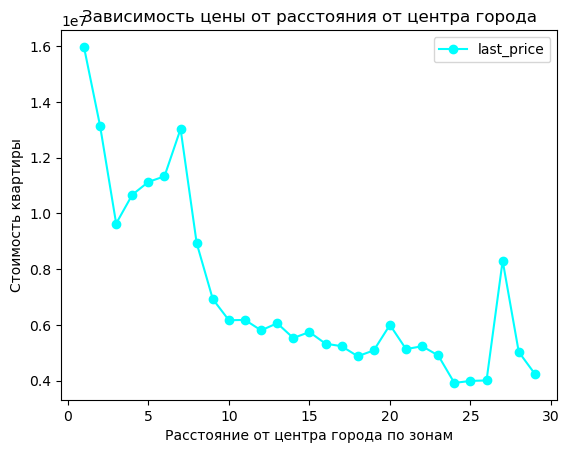

In [52]:
# вычисляем среднюю цену квартиры в каждой зоне
mean_price = data_spb.pivot_table(index='zones', values='last_price')
mean_price['zone'] = mean_price.index

# построим график зависимости цены от зоны расположения квартир
mean_price.plot(x='zone', y='last_price',
                title='Зависимость цены от расстояния от центра города', 
                style='o-', color='cyan');
plt.xlabel('Расстояние от центра города по зонам');
plt.ylabel('Стоимость квартиры');

В целом, средняя цена недвижимости падает в расстоянием от центра, что логично. Имеется аномальный провал в зонах между 2-м и 5-м километрами и аномальный пик в зоне между 26 и 28 км.

## Выводы

### 1. Параметры объектов недвижимости:
#### 1.1 Цены на практически все квартиры из датафрейма укладываются в ценовой дипазон до 10 млн. руб. 
#### 1.2 Распределение общих и жилых площадей квартир пуассоновское. Пиковое значение на 50 м2. Большая часть квартир имеет общую площадь до 75 м2, а жилую - до 60 м2. 
#### 1.3 Высота потолков варьируется от 2,4 до 3,2 метров. 
#### 1.4 Большинство квартир расположены на этажах с 1 до 3. Более трети квартир расположеныв пятиэтажках. Ещё по трети в высотках и средневысотных домах (от 6 до 12 этажей). 
#### 1.5 Площадь кухни в большинстве квартир до 10 м2. 
#### 1.6 Среднее расстояние до аэропорта - 30 км. 
#### 1.7 Большинство квартир находятся на расстоянии до 20 км от центра города Санкт-Петербург. 
#### 1.8 Большинство квартир расположено вблизи парков, на расстоянии до 1 км.

### 2. В будни продавцы размещают объявления чаще, чем в выходные, а зимой чаще, и меньше всего с мая по начало июня.

### 3. Быстро продаются квартиры со сроком размещения до 200 дней. Необычно долгими можно назвать те продажи, когда объявление держалось на сайте дольше 600 дней.

### 4. Количество квартир на первом и последнем этажах примерно одинаково и, что естественно, на порядок меньше, чем на остальных этажах.

### 5. Выявлена связь роста цены с ростом общей и жилой площадей, в меньшей степени - с площадью кухни и количеством комнат. Однако визуальный анализ говорит нам о влиянии других факторов на цену объекта.
### 6. Практически нет связи с типом этажа, однако медианные значения цены всё же несколько отличаются для разных типов. Самое низкое значение у квартир на первом этаже, самое высокое - у квартир на промежуточных этажах.

### 7. Больше всего объявлений разместили владельцы или риэлтора объектов недвижимости в населённых пунктах: город Санкт-Петербург, посёлки Мурино, Парголово, деревня Кудрово, посёлок Шушары, города Всеволожск, Пушкин, Колпино, Гатчина, Выборг. 

### 8. Самая высокая средняя цена одного квадратного метра в Санкт-Петербурге, самая низкая - в Гатчине.

### 9. В Санкт-Петербурге средняя цена недвижимости предсказуемо падает с расстоянием от центра. Однако присутсвуют аномальный провал в зонах между 2-м и 5-м километрами и аномальный пик в зоне между 26 и 28 км.